In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math

# load data
parts = pd.read_csv('Data/parts.csv')
sets = pd.read_csv('Data/sets.csv')
colors = pd.read_csv('Data/colors.csv')
inventories = pd.read_csv('Data/inventories.csv')
inventory_parts = pd.read_csv('Data/inventory_parts.csv')
minifigs = pd.read_csv('Data/minifigs.csv')
inventory_sets = pd.read_csv('Data/inventory_sets.csv')
inventory_minifigs = pd.read_csv('Data/inventory_minifigs.csv')
minifigures = pd.read_csv('Data/minifigs.csv')
categories = pd.read_csv('Data/part_categories.csv')
themes = pd.read_csv('Data/themes.csv')

In [81]:
##### Find the final parent of a theme and make a dict ####

final_parent = {}

parent_dict = dict(zip(themes['id'], themes['parent_id']))

def find_final_parent(id):
    parent = parent_dict[id]
    if math.isnan(parent):
        return int(id), themes.loc[themes['id'] == id, 'name'].iloc[0]
    else:
        return find_final_parent(parent)
    
final_parent_dict = {id: find_final_parent(id) for id in themes['id']}

print(final_parent_dict)

{1: (1, 'Technic'), 3: (1, 'Technic'), 4: (1, 'Technic'), 16: (1, 'Technic'), 17: (1, 'Technic'), 18: (1, 'Technic'), 19: (1, 'Technic'), 20: (1, 'Technic'), 21: (1, 'Technic'), 22: (22, 'Creator'), 23: (22, 'Creator'), 34: (34, 'Make & Create'), 35: (34, 'Make & Create'), 50: (50, 'Town'), 51: (50, 'Town'), 52: (52, 'City'), 53: (52, 'City'), 54: (52, 'City'), 55: (52, 'City'), 56: (52, 'City'), 57: (52, 'City'), 58: (52, 'City'), 59: (52, 'City'), 60: (52, 'City'), 61: (52, 'City'), 63: (52, 'City'), 64: (52, 'City'), 65: (52, 'City'), 66: (52, 'City'), 67: (50, 'Town'), 86: (50, 'Town'), 87: (50, 'Town'), 88: (50, 'Town'), 89: (50, 'Town'), 90: (50, 'Town'), 91: (50, 'Town'), 92: (50, 'Town'), 93: (50, 'Town'), 94: (50, 'Town'), 104: (50, 'Town'), 105: (50, 'Town'), 106: (50, 'Town'), 112: (112, 'Racers'), 114: (112, 'Racers'), 118: (112, 'Racers'), 122: (112, 'Racers'), 123: (112, 'Racers'), 126: (126, 'Space'), 127: (126, 'Space'), 128: (126, 'Space'), 129: (126, 'Space'), 130: (1

In [82]:
##### Merge data  #####

# merge left side of data structure
# merge categories with parts
categories_with_parts = pd.merge(categories, parts, left_on='id', right_on='part_cat_id')
categories_with_parts.rename(columns={'name_x': 'category_name', 'name_y': 'part_name', 'id': 'category_id'}, inplace=True)
categories_with_parts.drop('part_cat_id', axis=1, inplace=True)

# merge categories and parts with inventory_parts
categories_with_parts_with_inventory_parts = pd.merge(categories_with_parts, inventory_parts, left_on='part_num', right_on='part_num')
categories_with_parts_with_inventory_parts.drop('img_url', axis=1, inplace=True)

# merge inventory_parts with colors
categories_with_parts_with_colors_inventory_parts = pd.merge(categories_with_parts_with_inventory_parts, colors, left_on='color_id', right_on='id')
categories_with_parts_with_colors_inventory_parts.drop('color_id', axis=1, inplace=True)
categories_with_parts_with_colors_inventory_parts.rename(columns={'id': 'color_id', 'name': 'color_name', 'quantity': 'part_quantity'}, inplace=True)
categories_with_parts_with_colors_inventory_parts.to_csv('Merged_Data/inventory_parts.csv', index=False)


# merge middle of data structure
# merge minifgures with inventory_minifgures
minifigures_with_inventory_minifgures = pd.merge(minifigs, inventory_minifigs, left_on='fig_num', right_on='fig_num')
minifigures_with_inventory_minifgures.rename(columns={'name': 'minifig_name', 'quantity': 'minifig_quantitiy'}, inplace=True)
minifigures_with_inventory_minifgures.drop('img_url', axis=1, inplace=True)
minifigures_with_inventory_minifgures.to_csv('Merged_Data/inventory_minifigs.csv', index=False)

# merge right side of data structure
# merge sets with themes
sets_with_themes = pd.merge(sets, themes, left_on='theme_id', right_on='id')
sets_with_themes.drop(['img_url','theme_id'], axis=1, inplace=True)
sets_with_themes.rename(columns={'name_x': 'set_name', 'id': 'theme_id', 'name_y': 'theme_name'}, inplace=True)

for index, row in sets_with_themes.iterrows():                                      # just use over themes
    row_theme = row['theme_id']
    sets_with_themes.at[index, 'theme_id'] =  final_parent_dict[row_theme][0]
    sets_with_themes.at[index, 'theme_name'] =  final_parent_dict[row_theme][1]

sets_with_themes.drop('parent_id', axis=1, inplace=True)

#sets_with_themes = sets_with_themes[sets_with_themes.num_parts != 0]                  # delete all things that has no Lego parts
theme_names = sets_with_themes['theme_name'].unique()                                  # print themes
for name in theme_names:
    print(name)
print(len(themes))
sets_with_themes.to_csv('Merged_Data/inventory_sets.csv', index=False)


"""
# merge sets and themes with inventory_sets
sets_with_themes_inventory_sets = pd.merge(sets_with_themes, inventory_sets, left_on='set_num', right_on='set_num')
sets_with_themes_inventory_sets.rename(columns={'quantity': 'set_quantity'}, inplace=True)
sets_with_themes_inventory_sets.info()
sets_with_themes_inventory_sets.to_csv('Merged_Data/inventory_sets.csv', index=False)
"""

# merge all together
sets_with_inventory = pd.merge(sets_with_themes, inventories, left_on='set_num', right_on='set_num')

parts_with_inventory = pd.merge(categories_with_parts_with_colors_inventory_parts, sets_with_inventory, left_on='inventory_id', right_on='id')
parts_with_inventory.drop('id', axis=1, inplace=True)
parts_with_inventory.rename(columns={'num_parts': 'number_of_parts'}, inplace=True)

minifigs_with_inventory = pd.merge(minifigures_with_inventory_minifgures, sets_with_inventory, left_on='inventory_id', right_on='id')
minifigs_with_inventory.drop('id', axis=1, inplace=True)
minifigs_with_inventory.rename(columns={'num_parts_x': 'number_of_minifig_parts', 'num_parts_y': 'number_of_parts'}, inplace=True)


# filter data for the full years
data_parts = parts_with_inventory[parts_with_inventory['year'] <= 2023]
data_minifigs = minifigs_with_inventory[minifigs_with_inventory['year'] <= 2023]


# save full data 
data_minifigs.to_csv('Merged_Data/data_minifigs.csv', index=False)
data_parts.to_csv('Merged_Data/data_parts.csv', index=False)

Technic
Town
Castle
Space
Books
System
Duplo
Icons
Service Packs
Creator
Universal Building Set
Gear
Educational and Dacta
Train
Bulk Bricks
Star Wars
Hobby Sets
Bionicle
Discovery
Pirates
Seasonal
Super Heroes Marvel
Clikits
LEGO Brand Store
Sports
Harry Potter
Model Team
City
Other
Modular Buildings
Factory
Monster Fighters
Legoland
The Hobbit and Lord of the Rings
Adventurers
Mindstorms
Classic
Promotional
Make & Create
Juniors
Toy Story
Disney
Gabby’s Dollhouse
Super Heroes DC
Aquazone
Ninja
Ninjago
Minitalia
Primo
LEGO Originals
Hero Factory
Racers
Fabuland
Jurassic World
Rock Raiders
Studios
Alpha Team
4 Juniors
Monkie Kid
Value Packs
Building Set with People
Boat
Freestyle
Time Cruisers
BrickLink Designer Program
Architecture
Indiana Jones
FIRST LEGO League
Atlantis
Prince of Persia
LEGO Exclusive
Master Builder Academy
LEGO Ideas and CUUSOO
Minecraft
Fusion
LEGO Art
Homemaker
Elves
Belville
Nexo Knights
Western
Universe
Games
Pharaoh's Quest
Friends
Disney Princess
Cars
Pirates

In [83]:
#### merge data to final data structure to work with #####

# find relevant information
grouped_years = data_parts[['set_num','year']].drop_duplicates(subset='set_num')
grouped_themes = data_parts[['set_num','theme_id', 'theme_name']].drop_duplicates(subset='set_num')
grouped_parts = data_parts[['set_num','number_of_parts']].drop_duplicates(subset='set_num')
grouped_minifigs = data_minifigs.groupby('set_num')['minifig_quantitiy'].sum().reset_index()        # sum minifig_quantity per set
grouped_colors = data_parts.groupby(['set_num'])['color_id'].nunique().reset_index()  
grouped_categories = data_parts.groupby(['set_num'])['category_id'].nunique().reset_index()         # group by 'set_num' and 'year' and calculate the mean number of unique categories
data_unique_parts = data_parts[data_parts['part_quantity'] == 1]                                    # filter for parts with quantity 1
grouped_unique_parts = data_unique_parts.groupby(['set_num'])['part_num'].nunique().reset_index()
grouped_different_parts = data_parts.groupby(['set_num']).size().reset_index(name='count')

# merge data
merged = pd.merge(grouped_years, grouped_themes, on='set_num', how='left')
merged = pd.merge(merged, grouped_parts, on='set_num', how='left')
merged = pd.merge(merged, grouped_minifigs, on='set_num', how='left')
merged = pd.merge(merged, grouped_colors, on='set_num', how='left')
merged = pd.merge(merged, grouped_categories, on='set_num', how='left')
merged = pd.merge(merged, grouped_unique_parts, on='set_num', how='left')
merged = pd.merge(merged, grouped_different_parts, on='set_num', how='left')
merged.rename(columns={'color_id': 'number_of_colors', 'category_id': 'number_of_categories', 'id': 'category_id', 'part_num': 'number_of_unique_parts', 'count': 'number_of_different_parts'}, inplace=True)

merged.to_csv('Merged_Data/data.csv', index=False)
data = merged.copy()

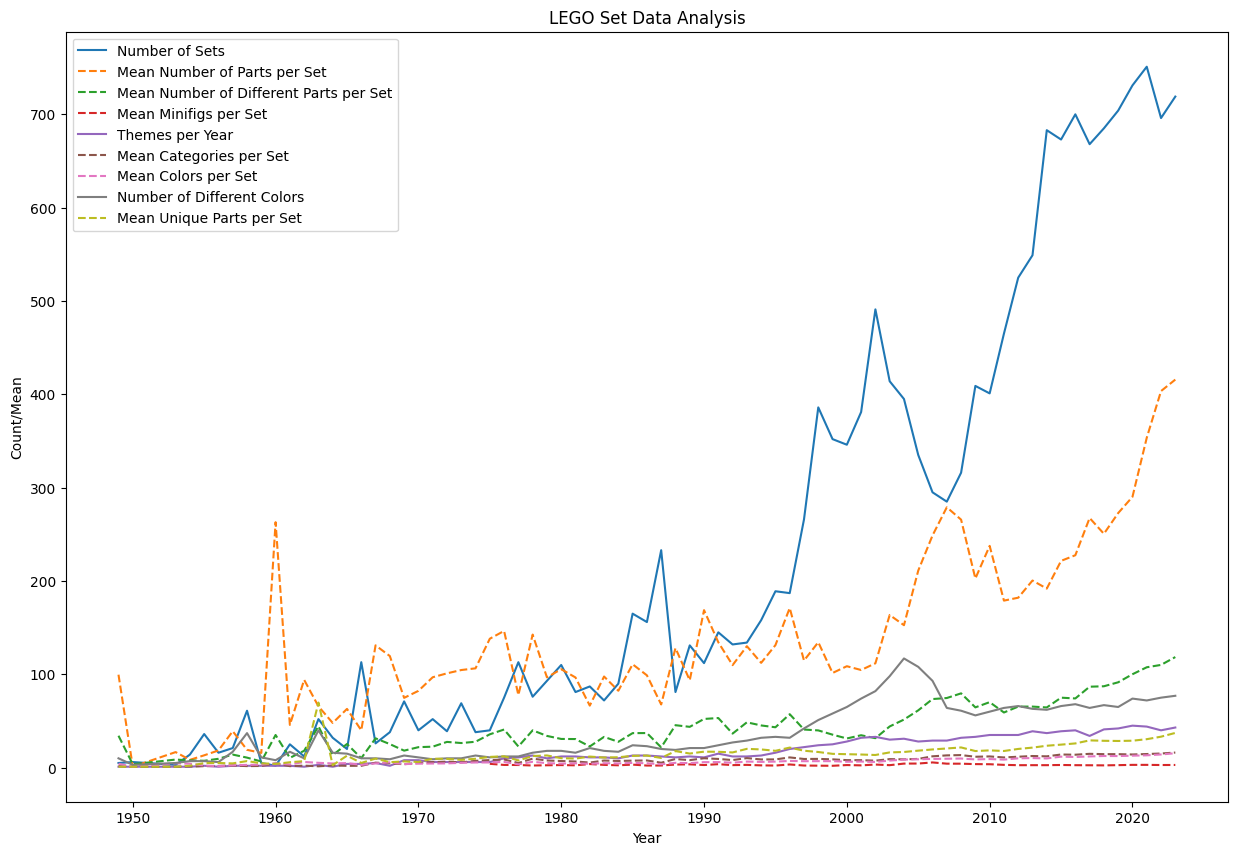

In [84]:
##### Analysis over the years and plot it#####

#### Calculations ###

# ensure 'year' is numeric
merged['year']= pd.to_numeric(merged['year'], errors='coerce') 

# calculate number of sets per year 
sets_per_year = merged.groupby('year')['set_num'].nunique()

# calculate mean number of parts per year per set
mean_parts_per_set_per_year = merged.groupby('year')['number_of_parts'].mean()

# calculate mean number of minifigs per year
mean_minifigs_per_set_per_year = merged.groupby('year')['minifig_quantitiy'].mean()

# calculate the mean number of colors per set
mean_colors_per_set_per_year = merged.groupby('year')['number_of_colors'].mean()

# calculate number of colors per year
grouped_colors = data_parts.groupby(['color_id', 'year']).size().reset_index(name='count')    # Count unique colors per year
colors_per_year = grouped_colors.groupby('year')['color_id'].count()                          # Calculate count per year

# calculate mean number of unique parts per set per year
mean_unique_parts_per_set_per_year = merged.groupby('year')['number_of_unique_parts'].mean()

# calculate the themes per year
themes_per_year = merged.groupby('year')['theme_id'].nunique()

# calculate the mean number of categories per set
mean_categories_per_set_per_year = merged.groupby('year')['number_of_categories'].mean()

# calculate the mean number of different parts per set
mean_number_of_different_parts_per_set_per_year = merged.groupby('year')['number_of_different_parts'].mean()


### Plot ###

# set up the plot for the analysis
plt.figure(figsize=(15, 10))

# plot number of sets per year
plt.plot(sets_per_year.index, sets_per_year, label='Number of Sets')

# plot mean number of parts per set per year
plt.plot(mean_parts_per_set_per_year.index, mean_parts_per_set_per_year, label='Mean Number of Parts per Set', linestyle='--')

# plot mean number of different parts per set per year
plt.plot(mean_number_of_different_parts_per_set_per_year.index, mean_number_of_different_parts_per_set_per_year, label='Mean Number of Different Parts per Set', linestyle='--')

# plot mean number of minifigs per set per year
plt.plot(mean_minifigs_per_set_per_year.index, mean_minifigs_per_set_per_year, label='Mean Minifigs per Set', linestyle='--')

# plot themes per year
plt.plot(themes_per_year.index, themes_per_year, label='Themes per Year')

# plot mean number of categories per set per year
plt.plot(mean_categories_per_set_per_year.index, mean_categories_per_set_per_year, label='Mean Categories per Set', linestyle='--')

# plot mean number of colors per set per year
plt.plot(mean_colors_per_set_per_year.index, mean_colors_per_set_per_year, label='Mean Colors per Set', linestyle='--')

# plot the number of colors per set per year
plt.plot(colors_per_year.index, colors_per_year, label='Number of Different Colors')

# plot mean number of unique parts per set per year
plt.plot(mean_unique_parts_per_set_per_year.index, mean_unique_parts_per_set_per_year, label='Mean Unique Parts per Set', linestyle='--')


# set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count/Mean')
plt.title('LEGO Set Data Analysis')
plt.legend()

# show the plot
plt.show()


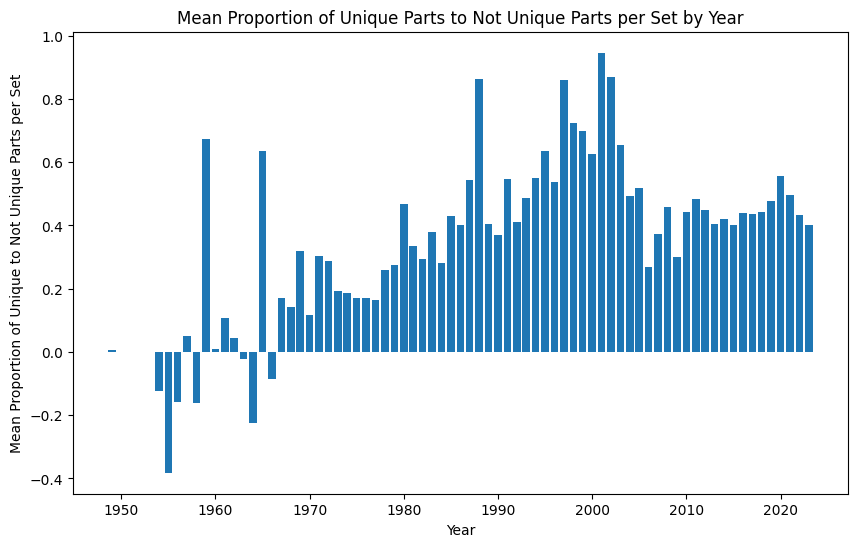

In [85]:
def plot_proportion(df):

    # calculate the proportion for each set
    df['not_unique_parts'] = df['number_of_parts'] - df['number_of_unique_parts']
    df['proportion_unique_to_not_unique'] = np.divide(df['number_of_unique_parts'], df['not_unique_parts'], out=np.zeros_like(df['number_of_unique_parts']), where=df['not_unique_parts']!=0)

    # group the data by year
    grouped = df.groupby('year')

    # calculate the mean proportion per set for each year
    df_yearly = grouped['proportion_unique_to_not_unique'].mean()

    # plot the results
    plt.figure(figsize=(10,6))
    plt.bar(df_yearly.index, df_yearly)
    plt.xlabel('Year')
    plt.ylabel('Mean Proportion of Unique to Not Unique Parts per Set')
    plt.title('Mean Proportion of Unique Parts to Not Unique Parts per Set by Year')
    plt.show()

plot_proportion(data)


In [86]:
##### Find the different themes in the last 23 years #####

df_filtered = data[(data['year'] >= 2000) & (data['year'] <= 2023)]       # filter for years 2000 to 2023
theme_names_last_years = df_filtered['theme_name'].unique()               # get unique themes per year

print(theme_names_last_years)         

['Pirates' 'City' 'Town' 'Castle' 'Educational and Dacta' 'Sports'
 'Creator' 'Modular Buildings' 'Games' 'Gear' 'Make & Create'
 'Designer Sets' 'Sculptures' 'BrickLink Designer Program' 'Harry Potter'
 'Super Mario' 'Star Wars' 'Ninjago' 'Seasonal' 'LEGO Ideas and CUUSOO'
 'Super Heroes Marvel' 'Disney' 'Avatar' 'Sonic The Hedgehog' 'Classic'
 'SpongeBob SquarePants' 'Cars' 'Toy Story' 'Studios' 'Super Heroes DC'
 'Legoland Parks' 'Racers' 'Inventor' 'Train' 'Juniors' 'Jurassic World'
 'FIRST LEGO League' 'Mixels' 'LEGO Brand Store' 'Exo-Force' 'Other'
 'The Hobbit and Lord of the Rings' 'LEGO Exclusive' 'X-Pod' 'Friends'
 'Disney Princess' 'Nexo Knights' 'Brickheadz' 'Indiana Jones' 'Factory'
 'Legends of Chima' 'Adventurers' 'The LEGO Movie' 'Trolls: World Tour'
 'Books' 'Promotional' 'Chinese Traditional Festivals' '4 Juniors'
 'Hidden Side' 'Icons' 'Space' 'Dimensions' 'Unikitty!' 'Fusion'
 'DC Super Hero Girls' 'Architecture' 'Minecraft' 'Brick Sketches'
 'Monkie Kid' 'Elves' 'D

theme_name
4 Juniors      48
Adventurers    40
Agents         27
Alpha Team     31
Angry Birds     6
               ..
VIDIYO         37
Vikings         8
Western         3
X-Pod          22
Xtra           19
Name: set_num, Length: 132, dtype: int64


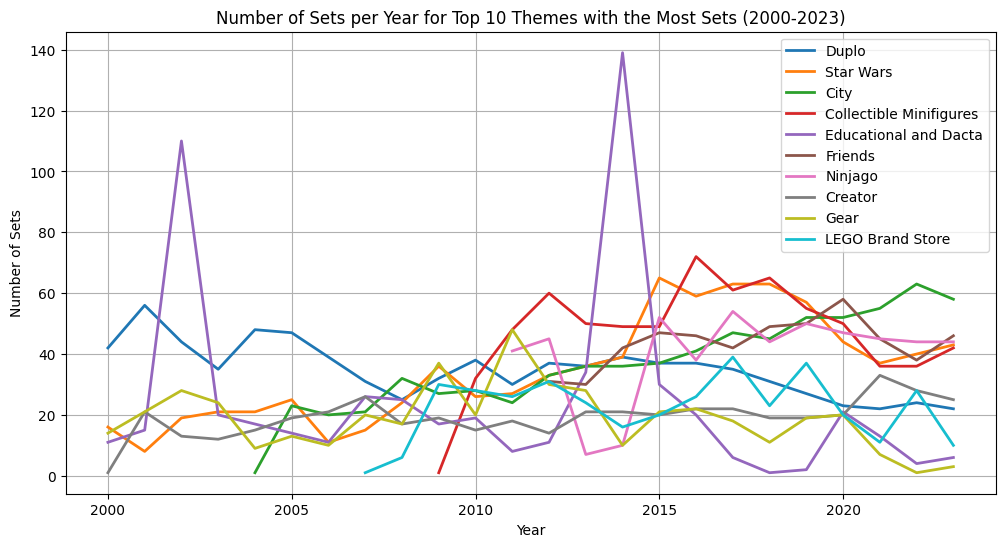

In [87]:
##### Plot the top 10 themes (most sets) over the years 2000 - 2023 #####

def plot_top_themes_and_sets(df):

    # filter rows between 2000 and 2023
    df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # group by theme_name and calculate the total number of sets for each theme
    theme_sets = df.groupby('theme_name')['set_num'].size()
    print(theme_sets)

    # get the top 10 themes with the most sets
    top_themes = theme_sets.nlargest(10).index

    # filter rows for top 10 themes
    df = df[df['theme_name'].isin(top_themes)]

    # group by year and theme_name, and count the number of sets
    df_grouped = df.groupby(['year', 'theme_name']).size().unstack()

    # plot
    plt.figure(figsize=(12, 6))
    for theme in top_themes:
        plt.plot(df_grouped.index, df_grouped[theme], marker='', linewidth=2, label=theme)

    plt.title('Number of Sets per Year for Top 10 Themes with the Most Sets (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_top_themes_and_sets(data)



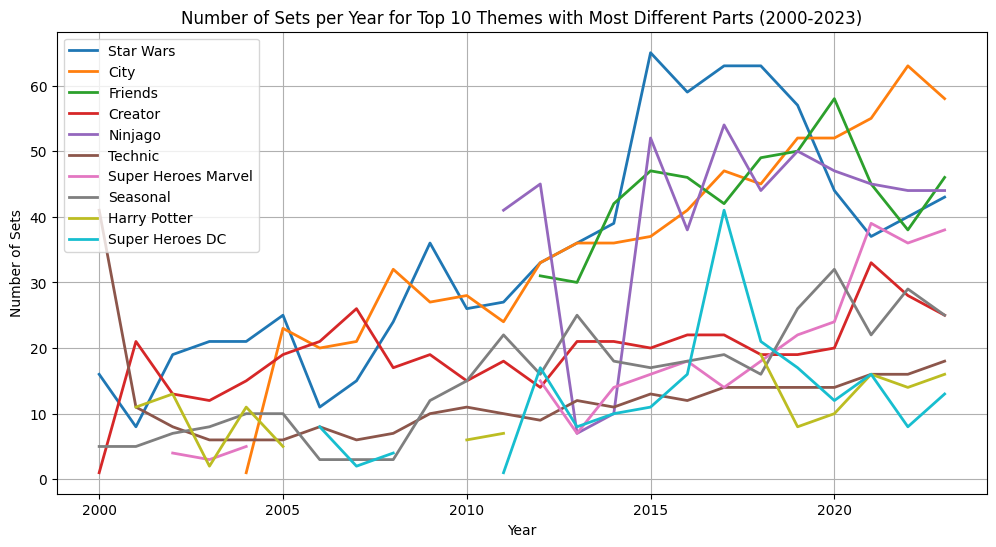

In [88]:
##### Plot the top 10 themes (most different parts) over the years 2000 - 2023 #####

def plot_top_themes_and_different_parts(df):
    # filter rows between 2000 and 2023
    df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # group by theme_name and calculate the total number of parts for each theme
    theme_parts = df.groupby('theme_name')['number_of_different_parts'].sum()

    # get the top 10 themes with the most parts
    top_themes = theme_parts.nlargest(10).index

    # filter rows for top 10 themes
    df = df[df['theme_name'].isin(top_themes)]

    # group by year and theme_name, and count the number of sets
    df_grouped = df.groupby(['year', 'theme_name']).size().unstack()

    # plot
    plt.figure(figsize=(12, 6))
    for theme in top_themes:
        plt.plot(df_grouped.index, df_grouped[theme], marker='', linewidth=2, label=theme)

    plt.title('Number of Sets per Year for Top 10 Themes with Most Different Parts (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_top_themes_and_different_parts(data)

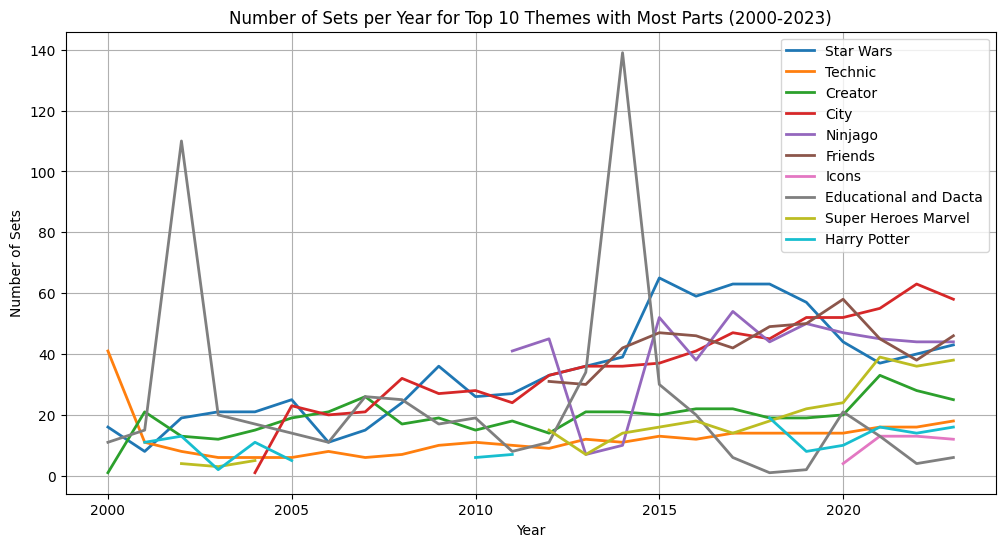

In [89]:
##### Plot the top 10 themes (most parts) over the years 2000 - 2023 #####

def plot_top_themes_and_parts(df):
    # filter rows between 2000 and 2023
    df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # group by theme_name and calculate the total number of parts for each theme
    theme_parts = df.groupby('theme_name')['number_of_parts'].sum()

    # get the top 10 themes with the most parts
    top_themes = theme_parts.nlargest(10).index

    # filter rows for top 10 themes
    df = df[df['theme_name'].isin(top_themes)]

    # group by year and theme_name, and count the number of sets
    df_grouped = df.groupby(['year', 'theme_name']).size().unstack()

    # plot
    plt.figure(figsize=(12, 6))
    for theme in top_themes:
        plt.plot(df_grouped.index, df_grouped[theme], marker='', linewidth=2, label=theme)

    plt.title('Number of Sets per Year for Top 10 Themes with Most Parts (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_top_themes_and_parts(data)

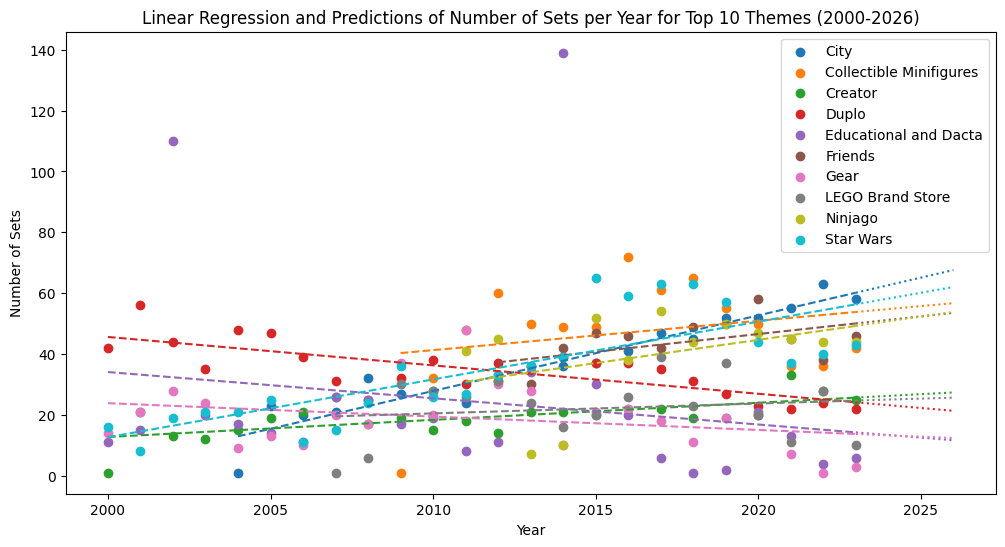

In [99]:
##### Make a linear regression for the number of sets with prediction until 2030 #####

def linear_regression_sets(df):

    # filter rows between 2000 and 2023
    df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # group by theme_name and calculate the total number of parts for each theme
    theme_sets = df.groupby('theme_name')['set_num'].size()

    # get the top 10 themes with the most parts
    top_themes = theme_sets.nlargest(10).index

    # filter rows for top 10 themes
    df_top_themes = df[df['theme_name'].isin(top_themes)]

    # sets per year
    sets_per_year = df_top_themes.groupby(['theme_name', 'year']).size().reset_index(name='number_of_sets')

    # initialize the model
    model = LinearRegression()

    plt.figure(figsize=(12, 6))

    for theme in sets_per_year['theme_name'].unique():
        data = sets_per_year[sets_per_year['theme_name'] == theme]
        x = data['year'].values.reshape(-1, 1)
        y = data['number_of_sets'].values
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        plt.scatter(x, y, label=theme)
        plt.plot(x, y_pred, linestyle='--')

        # make predictions until 2026
        x_future = np.arange(2023, 2027).reshape(-1, 1)
        y_future_pred = model.predict(x_future)
        plt.plot(x_future, y_future_pred, linestyle=':', color=plt.gca().lines[-1].get_color())

    # add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year for Top 10 Themes (2000-2026)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # show the plot
    plt.show()

# call the function
linear_regression_sets(data)

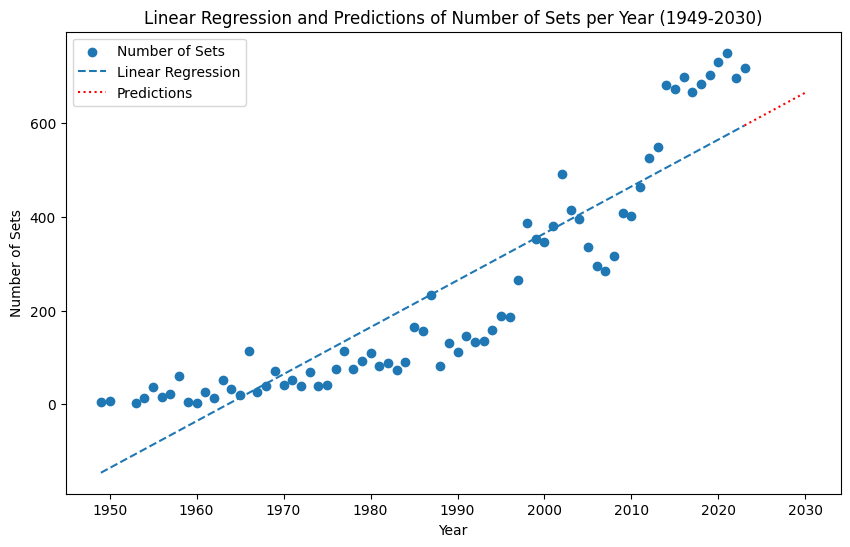

In [91]:
##### Make a linear regression for the number of sets with prediction until 2030 #####

def linear_regression_sets(df):

    # group by 'year', and count distinct 'set_num'
    sets_per_year = df.groupby('year').size().reset_index(name='number_of_sets')

    # create the plot
    plt.figure(figsize=(10, 6))
    x = sets_per_year['year'].values.reshape(-1, 1)
    y = sets_per_year['number_of_sets'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Sets')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # Make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year (1949-2030)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # show the plot
    plt.show()

# call the function
linear_regression_sets(data)

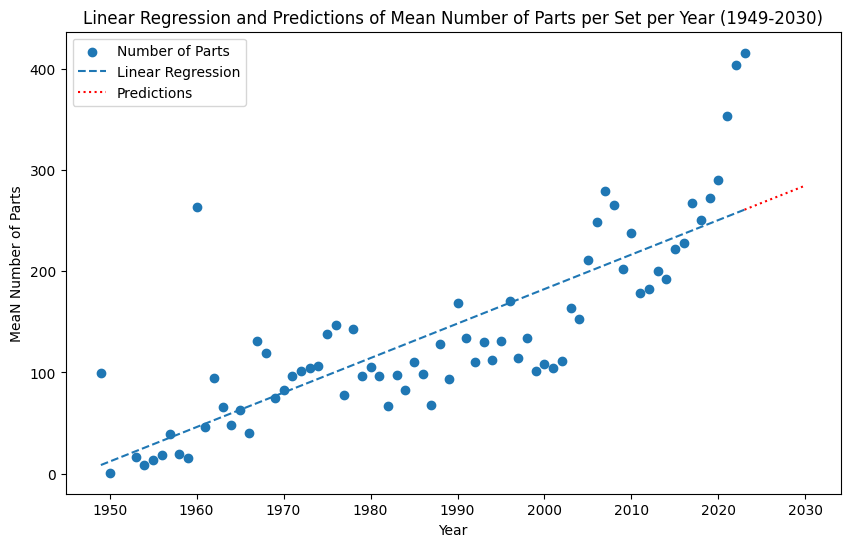

In [100]:
def linear_regression_parts(df):
    
    mean_parts_per_set_per_year = merged.groupby('year')['number_of_parts'].mean().reset_index(name='number_of_parts')

    # create the plot
    plt.figure(figsize=(10, 6))
    x = mean_parts_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_parts_per_set_per_year['number_of_parts'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Parts')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # add title and labels
    plt.title('Linear Regression and Predictions of Mean Number of Parts per Set per Year (1949-2030)')
    plt.xlabel('Year')
    plt.ylabel('MeaN Number of Parts')
    plt.legend()

    # show the plot
    plt.show()

# call the function with
linear_regression_parts(data)

Calculate Complexity with...:

...number_of_parts: More parts usually mean more complexity.
...number_of_colors: More colors can increase the difficulty of finding the right piece.
...number_of_categories: More categories of parts can increase the complexity.
...number_of_unique_parts: Unique parts may require specific placement, increasing complexity.
...number_of_different_parts: Different parts increase the variety of assembly methods, increasing complexity.

In [93]:
##### Calculate Complexity for each set #####

def calculate_complexity(df):

    # calculate complexity
    df['complexity_score'] = df['number_of_parts'] * df['number_of_colors'] * df['number_of_categories'] * df['number_of_unique_parts'] * df['number_of_different_parts']
    # normalize complexity
    df['complexity_score'] = (df['complexity_score'] - df['complexity_score'].min()) / (df['complexity_score'].max() - df['complexity_score'].min())
    return df

# call function
data_complexity = calculate_complexity(data)
data_complexity.to_csv('Merged_Data/data_complexity.csv', index=False)

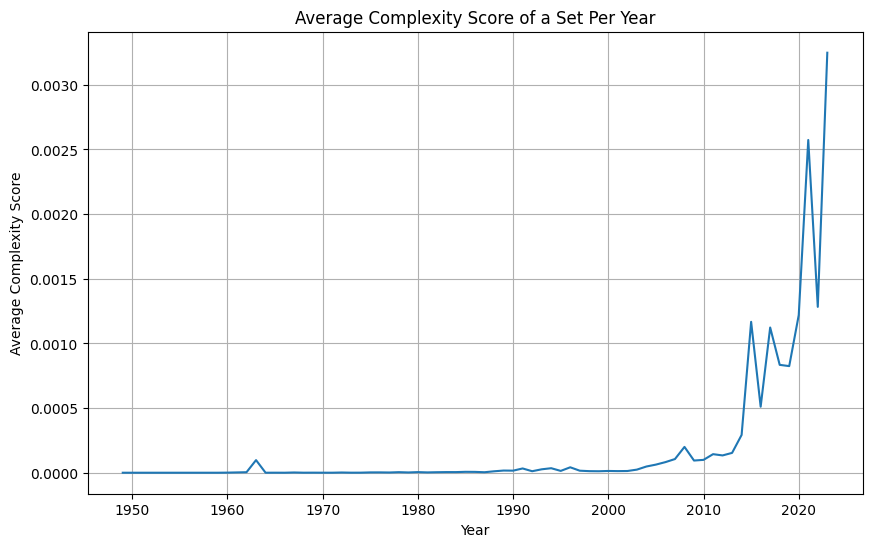

In [94]:
##### Plot mean complexity per set per year #####

def plot_set_complexitxy(df):
    # calculate mean number of complexity per set per year
    average_complexity_per_year = df.groupby('year')['complexity_score'].mean()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(average_complexity_per_year.index, average_complexity_per_year.values)
    plt.xlabel('Year')
    plt.ylabel('Average Complexity Score')
    plt.title('Average Complexity Score of a Set Per Year')
    plt.grid(True)
    plt.show()

# call function
plot_set_complexitxy(data_complexity)


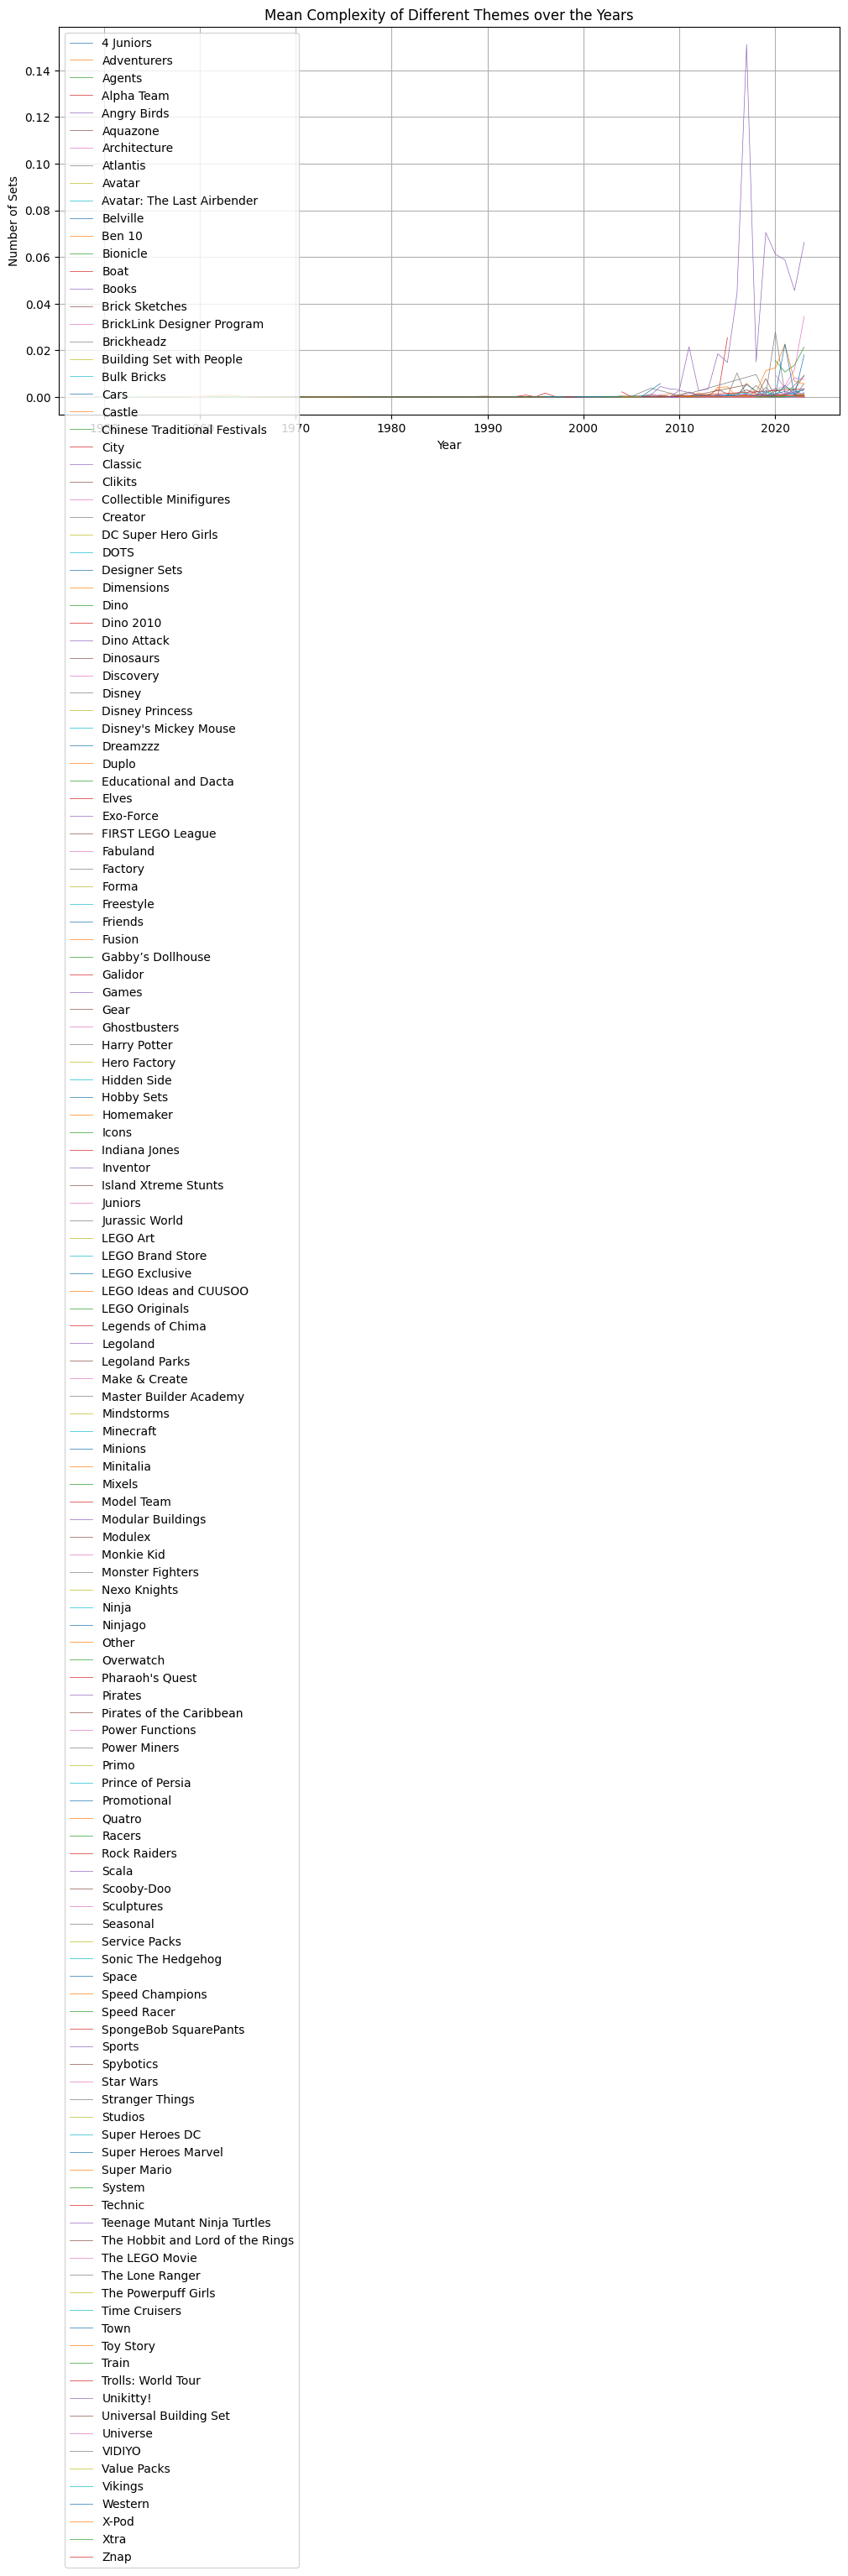

In [95]:
##### plot the complexity for different themes per year #####

def plot_themes_and_complexity(df):
    # calculate mean complexity
    mean_complexity = df.groupby(['theme_name', 'year'])['complexity_score'].mean().reset_index(name='complexity_score')

    # plot
    plt.figure(figsize=(12, 6))
    for theme in mean_complexity['theme_name'].unique():
        selected_theme_df = mean_complexity[mean_complexity['theme_name'] == theme]
        plt.plot(selected_theme_df['year'], selected_theme_df['complexity_score'], linewidth=0.5, label=theme)

    plt.title('Mean Complexity of Different Themes over the Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_themes_and_complexity(data_complexity)

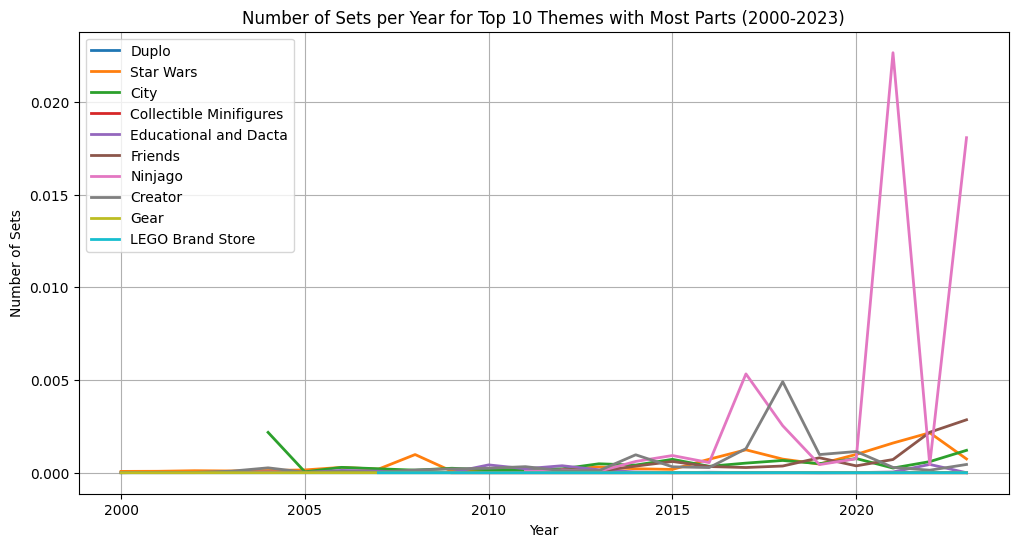

In [101]:
##### plot the complexity for different themes per year #####

def plot_top_themes_and_complexity(df):
    
    # filter rows between 2000 and 2023
    df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]


    # group by theme_name and calculate the total number of parts for each theme
    theme_sets = df.groupby('theme_name')['set_num'].size()

    # get the top 10 themes with the most sets
    top_themes = theme_sets.nlargest(10).index

    # filter rows for top 10 themes
    df = df[df['theme_name'].isin(top_themes)]

    # calculate mean complexity
    mean_complexity = df.groupby(['theme_name', 'year'])['complexity_score'].mean().reset_index(name='complexity_score')

    # plot
    plt.figure(figsize=(12, 6))
    for theme in top_themes:
        selected_theme_df = mean_complexity[mean_complexity['theme_name'] == theme]
        plt.plot(selected_theme_df['year'], selected_theme_df['complexity_score'], marker='', linewidth=2, label=theme)

    plt.title('Number of Sets per Year for Top 10 Themes with Most Parts (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_top_themes_and_complexity(data_complexity)

In [97]:
##### Create a list with ascending complexity over all years #####

# Calculate average complexity for each theme
average_complexity = data_complexity.groupby('theme_name')['complexity_score'].mean().reset_index()

# Sort the list by average complexity in descending order
sorted_list = average_complexity.sort_values(by='complexity_score', ascending=False)

print(sorted_list)

                     theme_name  complexity_score
56                 Ghostbusters      3.276843e-02
84            Modular Buildings      3.272117e-02
62                        Icons      1.512788e-02
16   BrickLink Designer Program      9.890746e-03
117             Stranger Things      8.318841e-03
..                          ...               ...
53                      Galidor      4.657403e-10
11                       Ben 10      2.915178e-10
96              Power Functions      1.493727e-10
138                 Value Packs      1.032226e-13
85                      Modulex               NaN

[144 rows x 2 columns]


In [98]:
##### General Information about data set ####

number_of_sets =data_parts['set_num'].nunique()
print(f'Number of Sets: {number_of_sets}')
number_of_parts = data_parts['part_num'].nunique()
print(f'Number of Parts: {number_of_parts}')
number_of_minifigs = data_minifigs['fig_num'].nunique()
print(f'Number of Minifigures: {number_of_minifigs}')
number_of_themes = data_parts['theme_name'].nunique()
print(f'Number of Themes: {number_of_themes}')
number_of_colors = data_parts['color_id'].nunique()
print(f'Numer of Colors: {number_of_colors}')
number_of_categories = data_parts['category_id'].nunique()
print(f'Numer of Categories: {number_of_categories}')

Number of Sets: 17077
Number of Parts: 35408
Number of Minifigures: 13546
Number of Themes: 144
Numer of Colors: 251
Numer of Categories: 66
